In [90]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt, dates
import matplotlib.dates as mdates
from matplotlib.rcsetup import validate_any

**Tarefa 1: Identificação de Dados**

Fonte de dados utilizada Para esta análise:

[Portal Brasileiro de Dados Abertos do Banco Central](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries)

[Sobre o Portal do Banco Central](https://dadosabertos.bcb.gov.br/pages/sobre-o-portal)

Séries de dados utilizadas: 
* Reservas internacionais - Total - diária = (13621) - Fonte BCB-DSTAT

Premissas:

Geridas pelo Banco Central, as “reservas internacionais” são os ativos em moedas estrangeiras que servem basicamente como um “seguro” da economia do país para fazer frente às suas obrigações no exterior e a choques externos, como uma desvalorização mais forte da moeda local.

Composição da reserva:

dólar norte-americano: 80,34%
euro: 5,04%
renminbi (China): 4,99%
libra esterlina (Reino Unido): 3,47%
ouro: 2,25%
iene (Japão): 1,93%
dólar canadense (Canadá): 1,01%
dólar australiano (Austrália): 0,97%

Investimentos da reserva:

títulos governamentais: 89,26%
depósitos em bancos centrais e em sistemas supranacionais: 3,61%
títulos de agências: 1,64%
ETFs de índices de ações: 1,13%
títulos de sistemas supranacionais: 0,63%
depósitos em bancos comerciais: 0,47%
ETFs de Corporates Investment Grade: 0,44%
ouro: 2,25%
outras classes, como títulos de governos locais: 0,58%

**Tarefa 2: Coleta de Dados**

Definindo Constantes

Como a API usa códigos, criamos um mapeamento entre os códigos e nomes significativos para usar ao analisar e armazenar os dados.

**Buscar dados por meio de chamadas de API**

As funções a seguir foram escritas para fazer uma chamada de API por recurso e buscar os dados. Cada uma dessas funções executa as seguintes tarefas:

*consulta_bc( )*: Função que realizará a consulta via API do BANCO CENTRAL DO BRASIL.

*grafico_periodo_suavizado( )*: Função que plota os gráficos referentes aos governos específicados por df, inicio, fim (governos) suavizando dados diários em médias quinzenal.

In [3]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

def grafico_periodo_suavizado(df, inicio, fim):
  periodo = df[(df.index >= inicio) & (df.index <= fim)]  
  periodo['reserva'].resample("15d", label="right").mean().plot()

Definição dos datasets e chamada das consultas através dos códigos BCB, que retornará os Datasets específicados

In [4]:
# Definição dos códigos BCB, que retorna um Dataset específico
reservas_internacionais = consulta_bc(13621)

**Tarefa 3: Pré-processamento de dados**

Os dados acima foram coletados e atribuídos a datasets individuais por meio de várias chamadas de API.

Definição dos Dataframes (Total, média anual, mínimo do ano, máximo do ano, cópia do dataset para analise por governos)

In [5]:
# Definição dos códigos BCB e Consulta dos datasets
data_inicio = '1999-01-01'

In [6]:
reservas_int = reservas_internacionais[reservas_internacionais.index >= data_inicio]
reservas_int_ano_media = reservas_int.groupby(pd.PeriodIndex(reservas_int.index, freq="Y")).mean()
reservas_int_ano_mediana = reservas_int.groupby(pd.PeriodIndex(reservas_int.index, freq="Y")).median()
reservas_int_ano_min = reservas_int.groupby(pd.PeriodIndex(reservas_int.index, freq="Y")).min()
reservas_int_ano_max = reservas_int.groupby(pd.PeriodIndex(reservas_int.index, freq="Y")).max()

reservas_governo = reservas_internacionais
reservas_governo.columns =['reserva']

**Alteração de tipos**

Podemos observar que a coluna 'Data' é um valor numérico, mas os novos dados são anuais.

Convertendo os valores para INT e os indexes para String

Retornamos o dataframes atualizados convertidos para que os valores sejam representados corretamente.

In [7]:
reservas_int_ano_media = reservas_int_ano_media.astype(int)
reservas_int_ano_media.index = reservas_int_ano_media.index.map(str)

reservas_int_ano_mediana = reservas_int_ano_mediana.astype(int)
reservas_int_ano_mediana.index = reservas_int_ano_mediana.index.map(str)

reservas_int_ano_min = reservas_int_ano_min.astype(int)
reservas_int_ano_min.index = reservas_int_ano_min.index.map(str)

reservas_int_ano_max = reservas_int_ano_max.astype(int)
reservas_int_ano_max.index = reservas_int_ano_max.index.map(str)

**Alteração de tipos**

Podemos observar que a coluna 'Data' é um valor numérico, e os valores são separados por " , " e não " . ".

Convertemos os formatos para datetime e float 

Conversão dos valores para BI US$.

Retornamos o dataframes atualizados convertidos para que os valores sejam representados corretamente.

In [8]:
reservas_governo.index = pd.to_datetime(reservas_governo.index, format='%d%m%Y')
reservas_governo = reservas_governo.replace(',','.', regex=True).astype(float)
reservas_governo = reservas_governo/1000

In [9]:
reservas_governo

,reserva
data,
1998-09-01,65.969
1998-09-02,63.083
1998-09-03,61.984
1998-09-04,60.702
1998-09-08,59.449
...,...
2022-12-27,327.065
2022-12-28,326.351
2022-12-29,324.792


**Tarefa 5: Criação de um Dataframe com a Evolução das Reservas por governo**

Definir um dataframe com os dados:

* Presidente
* Início Gov
* Fim Gov
* Reserva Início Gov Bi USD
* Reserva Fim Gov Bi USD
* Evolução Real
* Evolução %

In [53]:
# Definição de periodos governamentais
Presidente = ['2º Fernando Henrique Cardoso', '1º Luiz Inácio Lula da Silva', '2º Luiz Inácio Lula da Silva', '1º Dilma Rousseff', '2º Dilma Rousseff/Michel Temer', '1º Jair Bolsonaro']
inicio_gov = ['1998-09-01', '2003-01-02', '2007-01-02', '2011-01-03', '2015-01-02', '2019-01-02']
fim_gov = ['2002-12-31', '2006-12-29', '2010-12-31', '2014-12-31', '2018-12-31', '2022-12-30']

In [54]:
#Definindo os valores de Reserva nos inicios de governo
reserva_inicio_gov = reservas_internacionais.loc[reservas_internacionais.index.isin(inicio_gov)]
reserva_inicio_gov = reserva_inicio_gov.dropna(axis=0)
reserva_inicio_gov = list(reserva_inicio_gov.itertuples(index=False, name=None))
reserva_inicio_gov = ["%.0f" % elem for elem in reserva_inicio_gov]
reserva_inicio_gov
new_reserva_inicio_gov = []
for elem in reserva_inicio_gov:
    new_reserva_inicio_gov.append(float(elem[:-1])/100)
print(new_reserva_inicio_gov)

[65.96, 37.65, 86.43, 289.09, 362.91, 374.72]


In [55]:
#Definindo os valores de Reserva nos fins de governo
reserva_fim_gov = reservas_internacionais.loc[reservas_internacionais.index.isin(fim_gov)]
reserva_fim_gov = reserva_fim_gov.dropna(axis=0)
reserva_fim_gov = list(reserva_fim_gov.itertuples(index=False, name=None))
reserva_fim_gov = ["%.0f" % elem for elem in reserva_fim_gov]
new_reserva_fim_gov = []
for elem in reserva_fim_gov:
    new_reserva_fim_gov.append(float(elem[:-1])/100)
print(new_reserva_fim_gov)

[37.82, 85.83, 288.57, 363.55, 374.71, 324.7]


In [56]:
#Evolução Real das Reservas em Bilhões US$
array1 = np.array(reservas_internacionais.loc[reservas_internacionais.index.isin(fim_gov)])
array2 = np.array(reservas_internacionais.loc[reservas_internacionais.index.isin(inicio_gov)])
subtracted_array = np.subtract(array1, array2)
subtracted_array = ["%.0f" % elem for elem in subtracted_array]
reserva_evol_real = list(subtracted_array)
new_reserva_evol_real = []
for elem in reserva_evol_real:
    new_reserva_evol_real.append(float(elem[:-1])/100)
print(new_reserva_evol_real)

[-28.14, 48.18, 202.13, 74.46, 11.8, -50.01]


In [57]:
#Evolução percentual das Reservas
reserva_evol_perc = ((array1 / array2)-1)*100
reserva_evol_perc = ["%.2f" % elem for elem in reserva_evol_perc]
new_reserva_evol_perc = []
for elem in reserva_evol_perc:
    new_reserva_evol_perc.append(float(elem))
print(new_reserva_evol_perc)

[-42.67, 127.98, 233.85, 25.76, 3.25, -13.35]


In [65]:
#Min das Reservas
min_fhc = reservas_int.loc['1998-09-01':'2002-12-31'].min()
min_lula = reservas_int.loc['2003-01-02':'2006-12-29'].min()
min_lula2 = reservas_int.loc['2007-01-02':'2010-12-31'].min()
min_dilma = reservas_int.loc['2011-01-03':'2014-12-31'].min()
min_dilma2 = reservas_int.loc['2015-01-02':'2018-12-31'].min()
min_bolsonaro = reservas_int.loc['2019-01-02':'2023-01-01'].min()

In [66]:
#max das Reservas
max_fhc = reservas_int.loc['1998-09-01':'2002-12-31'].max()
max_lula = reservas_int.loc['2003-01-02':'2006-12-29'].max()
max_lula2 = reservas_int.loc['2007-01-02':'2010-12-31'].max()
max_dilma = reservas_int.loc['2011-01-03':'2014-12-31'].max()
max_dilma2 = reservas_int.loc['2015-01-02':'2018-12-31'].max()
max_bolsonaro = reservas_int.loc['2019-01-02':'2023-01-01'].max()

In [67]:
min = [min_fhc,min_lula,min_lula2,min_dilma,min_dilma2,min_bolsonaro]
min = ["%.2f" % elem for elem in min]
new_min = []
for elem in min:
    new_min.append(float(elem[:-1])/1000)
print(new_min)

[27.516, 37.652, 86.428, 288.631, 356.094, 323.49]


In [68]:
max = [max_fhc,max_lula,max_lula2,max_dilma,max_dilma2,max_bolsonaro]
max = ["%.2f" % elem for elem in max]
new_max = []
for elem in max:
    new_max.append(float(elem[:-1])/1000)
print(new_max)

[44.819, 85.839, 288.575, 379.82, 383.662, 390.51]


In [69]:
#Criação do dataframe com os dados por governo
governos = list(zip(Presidente,inicio_gov,fim_gov,new_reserva_inicio_gov,new_reserva_fim_gov,new_reserva_evol_real,new_reserva_evol_perc,new_min,new_max))
governos
gov = pd.DataFrame(governos, columns=['Presidente','Início Gov','Fim Gov','Reserva Início Gov Bi (US$)','Reserva Fim Gov Bi (US$)','Evolução Real','Evolução %','Reserva Mín','Reserva Máx'])
gov

,Presidente,Início Gov,Fim Gov,Reserva Início Gov Bi (US$),Reserva Fim Gov Bi (US$),Evolução Real,Evolução %,Reserva Mín,Reserva Máx
0,2º Fernando Henrique Cardoso,1998-09-01,2002-12-31,65.96,37.82,-28.14,-42.67,27.516,44.819
1,1º Luiz Inácio Lula da Silva,2003-01-02,2006-12-29,37.65,85.83,48.18,127.98,37.652,85.839
2,2º Luiz Inácio Lula da Silva,2007-01-02,2010-12-31,86.43,288.57,202.13,233.85,86.428,288.575
3,1º Dilma Rousseff,2011-01-03,2014-12-31,289.09,363.55,74.46,25.76,288.631,379.820
4,2º Dilma Rousseff/Michel Temer,2015-01-02,2018-12-31,362.91,374.71,11.80,3.25,356.094,383.662
5,1º Jair Bolsonaro,2019-01-02,2022-12-30,374.72,324.70,-50.01,-13.35,323.490,390.510


In [70]:
gov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Presidente                   6 non-null      object 
 1   Início Gov                   6 non-null      object 
 2   Fim Gov                      6 non-null      object 
 3   Reserva Início Gov Bi (US$)  6 non-null      float64
 4   Reserva Fim Gov Bi (US$)     6 non-null      float64
 5   Evolução Real                6 non-null      float64
 6   Evolução %                   6 non-null      float64
 7   Reserva Mín                  6 non-null      float64
 8   Reserva Máx                  6 non-null      float64
dtypes: float64(6), object(3)
memory usage: 560.0+ bytes


**Tarefa 4: Análise e representação dos conjuntos de dados processados**

Como temos todos os conjuntos de dados pré-processados, podemos criar visualizações a partir deles para identificar padrões. 
Usei as bibliotecas matplotlib e seaborn para analisar os dados.

**Analisando a Evolução das Reservas Internacionais Brasileiras Por Presidente da República**

Plotamos os datasets *reservas_governo* atribuídos na chamada da função *grafico_periodo_gov( )* junto aos períodos governamentais.

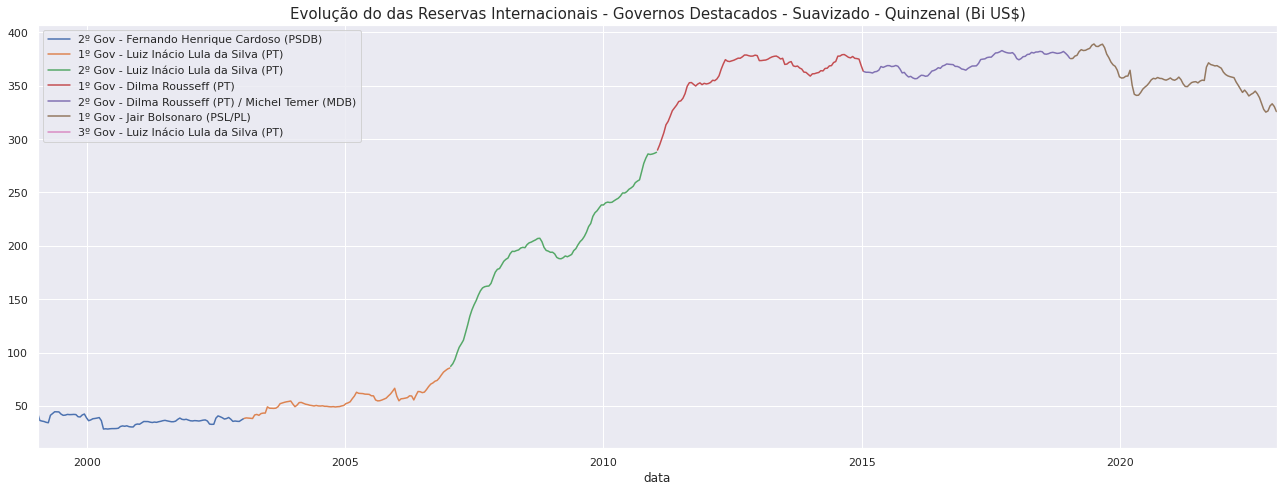

In [118]:
plt.rcParams['figure.figsize'] = (18,7)
plt.title('Evolução do das Reservas Internacionais - Governos Destacados - Suavizado - Quinzenal (Bi US$)', fontsize=15)
grafico_periodo_suavizado(reservas_governo, '1999-01-01', '2002-12-31')
grafico_periodo_suavizado(reservas_governo, '2003-01-01', '2006-12-31')
grafico_periodo_suavizado(reservas_governo, '2007-01-01', '2010-12-31')
grafico_periodo_suavizado(reservas_governo, '2011-01-01', '2014-12-31')
grafico_periodo_suavizado(reservas_governo, '2015-01-01', '2018-12-31')
grafico_periodo_suavizado(reservas_governo, '2019-01-01', '2023-01-01')
grafico_periodo_suavizado(reservas_governo, '2023-01-01', '2027-01-01')
plt.legend(['2º Gov - Fernando Henrique Cardoso (PSDB)',
            '1º Gov - Luiz Inácio Lula da Silva (PT)',
            '2º Gov - Luiz Inácio Lula da Silva (PT)',
            '1º Gov - Dilma Rousseff (PT)',
            '2º Gov - Dilma Rousseff (PT) / Michel Temer (MDB)',
            '1º Gov - Jair Bolsonaro (PSL/PL)',
            '3º Gov - Luiz Inácio Lula da Silva (PT)'])

plt.tight_layout()
plt.show()

**Analisando a Evolução da Dívida Externa Bruta Brasileira (Média, Mínimo, Máximo)**

Plotamos os datasets *reservas_int_ano_media, reservas_int_ano_max,  reservas_int_ano_min*.


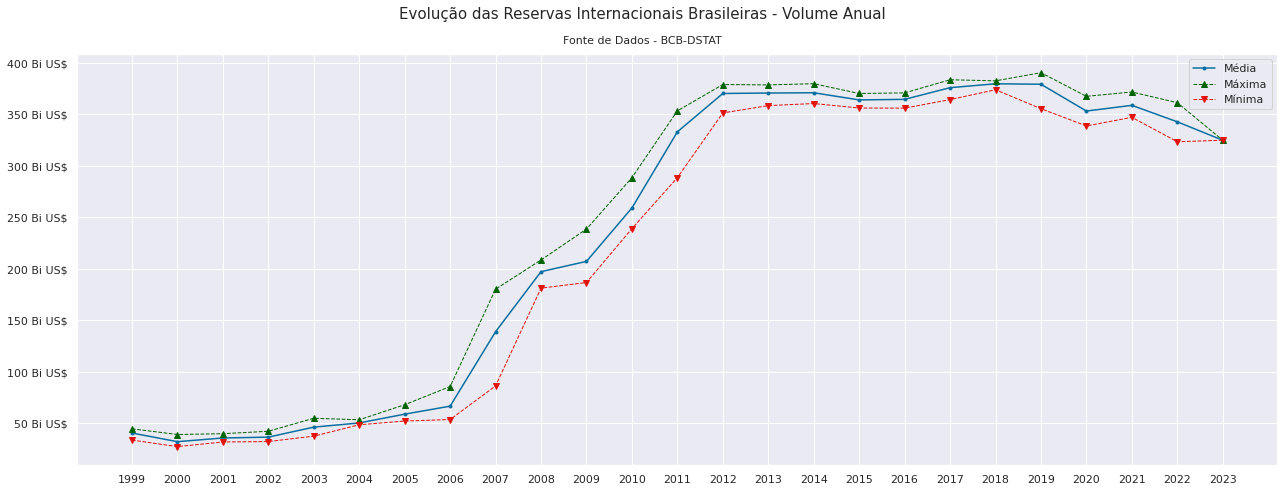

In [121]:
matplotlib.rcParams['figure.figsize'] = (18,7)
fig, (ax1) = plt.subplots(1, sharex=False)
#Títulos do gráfico
plt.text(x=0.5, y=0.95, s= "Evolução das Reservas Internacionais Brasileiras - Volume Anual", fontsize=15, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.90, s= "Fonte de Dados - BCB-DSTAT", fontsize=11, ha="center", transform=fig.transFigure)
#Plotagem das Séries
ax1.plot(reservas_int_ano_media, color='#076FA1', marker='.')
ax1.plot(reservas_int_ano_max, color='#006400', marker='^', linestyle='--', linewidth=1.0)
ax1.plot(reservas_int_ano_min, color='#E3120B', marker='v', linestyle='--', linewidth=1.0)
#Legenda dos Rótulos
ax1.legend(['Média','Máxima','Mínima'])
#Escalando os valores e transformando os eixos y em BI US$
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g} Bi US$'.format(x/scale_y))
ax1.yaxis.set_major_formatter(ticks_y)

fig.tight_layout()
plt.show()

**Analisando a Evolução da Dívida Externa Bruta Brasileira Por Presidente (Bi USD)**

Plotamos os dados de *evolução real* dos periodos governamentais


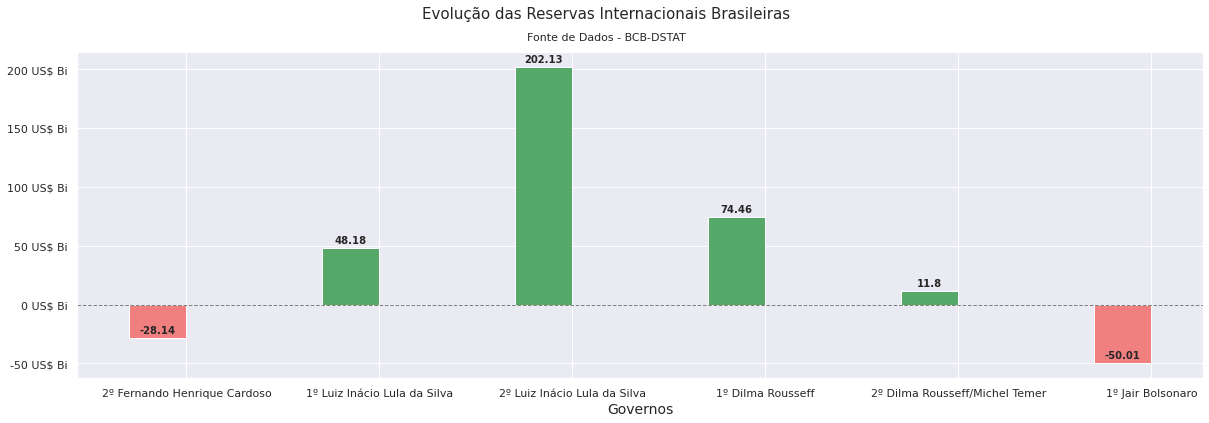

In [124]:
x = np.arange(len(Presidente)) # the label locations
width = 0.30 # the width of the bars
matplotlib.rcParams['figure.figsize'] = (17,6)
fig, ax = plt.subplots()
#Títulos do gráfico
plt.text(x=0.5, y=0.95, s= "Evolução das Reservas Internacionais Brasileiras", fontsize=15, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.90, s= "Fonte de Dados - BCB-DSTAT", fontsize=11, ha="center", transform=fig.transFigure)
ax.set_xticks(x)
ax.set_xticklabels(Presidente)
#Definição de cores caso positivo ou negativo
color = ['lightcoral' if y<0 else 'g' for y in new_reserva_evol_real]
#Plor criando as anotações dos valores de rótulos
pps = ax.bar(x - width/2, new_reserva_evol_real, width, label='Evolução Reservas (US$ Bi)', color=color)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=10, weight="bold")

#Escalando os valores e transformando os eixos y em BI US$
scale_y = 1
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g} US$ Bi'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
#Imprimindo uma linha em y=0.0
plt.axhline(y=0.0, color='grey', linewidth=1.0, linestyle='--')
ax.set_xlabel('Governos',fontsize=(14))

fig.tight_layout()
plt.show()

**Analisando a Evolução da Dívida Externa Bruta Brasileira Por Presidente (%)**

Plotamos os dados de *evolução percentual* dos periodos governamentais


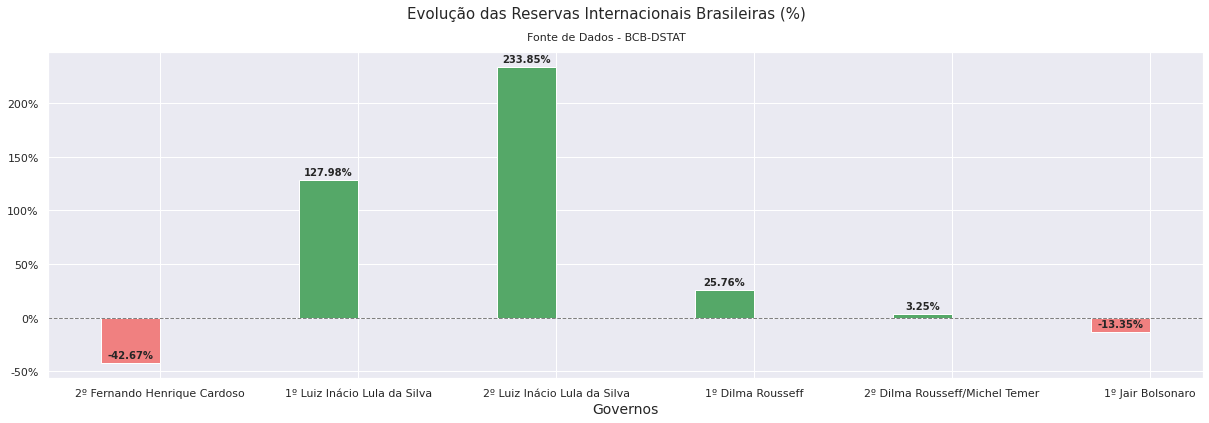

In [127]:
x = np.arange(len(Presidente)) # the label locations
width = 0.30 # the width of the bars
matplotlib.rcParams['figure.figsize'] = (17,6)
fig, ax = plt.subplots()
#Títulos do gráfico
plt.text(x=0.5, y=0.95, s= "Evolução das Reservas Internacionais Brasileiras (%)", fontsize=15, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.90, s= "Fonte de Dados - BCB-DSTAT", fontsize=11, ha="center", transform=fig.transFigure)
ax.set_xticks(x)
ax.set_xticklabels(Presidente)
#Definição de cores caso positivo ou negativo
color = ['lightcoral' if y<0 else 'g' for y in new_reserva_evol_perc]
#Plor criando as anotações dos valores de rótulos
pps = ax.bar(x - width/2, new_reserva_evol_perc, width, label='Evolução %', color=color)
for p in pps:
   height = p.get_height()
   ax.annotate('{}%'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=10, weight="bold")   

#Escalando os valores e transformando os eixos y em BI US$
scale_y = 1
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}%'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

#Imprimindo uma linha em y=0.0
plt.axhline(y=0.0, color='grey', linewidth=1.0, linestyle='--')
ax.set_xlabel('Governos',fontsize=(14))
fig.tight_layout()

plt.show()

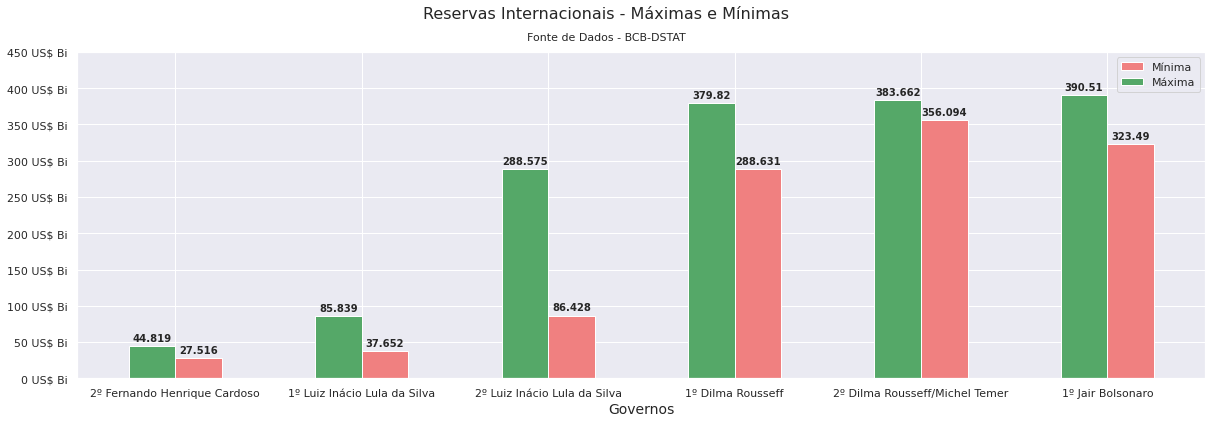

In [126]:
x = np.arange(len(gov))  # the label locations
largura = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(17,6), sharey=True)

min = ax.bar(x + largura/2, gov['Reserva Mín'], largura, label='Mínima', color='lightcoral')
for p in min:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=10, weight="bold") 

max = ax.bar(x - largura/2, gov['Reserva Máx'], largura, label='Máxima', color='g')
for p in max:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=10, weight="bold") 
   
# Nomeando a tabela
plt.text(x=0.5, y=0.95, s= "Reservas Internacionais - Máximas e Mínimas", fontsize=16, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.90, s= "Fonte de Dados - BCB-DSTAT", fontsize=11, ha="center", transform=fig.transFigure)
ax.set_xlabel('Governos',fontsize=(14))

#Escalando os valores e transformando os eixos y em BI US$
scale_y = 1
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g} US$ Bi'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.legend()
ax.set_ylim([0,450])
ax.set_xticks(x)
ax.set_xticklabels(gov['Presidente'])

fig.tight_layout()
plt.show()